In [1]:
# As seen in 2.1, activity over the entire space can sometimes be very hig or low
# instead of the desired 0
# this is due to the mutltiple layers in the NN,
# while the first layer appropriately outputs zero over unseen regions
# there is not guarantee that the zero vector is unseen space for the second layer
# to remedy this I introduced 'random-eval' in the previous notebook.

# In this notebook I explore other ideas to solve this issues.

# idea 1: add noise to training
#  - does it work? how does it compare to adding  noise to training for classical nets?
#  - A: does not see to work 

# idea 2: set biases of all but first layer to zero and don't update them


In [2]:
from __future__ import print_function

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
import scipy as sp
from scipy import stats
from sklearn import datasets as skdatasets

import sys
sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research/')
import Finite_Gaussian_Network_lib as fgnl
import Finite_Gaussian_Network_lib.fgn_helper_lib as fgnh

In [5]:
!gpustat

crescent                Tue Apr 14 17:02:55 2020  418.87.01
[0] GeForce RTX 2080 Ti | 75'C,  36 % |  9561 / 10989 MB | arsyed(9551M)
[1] GeForce RTX 2080 Ti | 85'C,  79 % |  8053 / 10989 MB | soumi(8043M)


In [6]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda = False
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
print("Using device:", device)

# manualy set cuda device
torch.cuda.set_device(0)

CUDA Available:  True
Using device: cpu


In [7]:
# # random seeds
# torch.manual_seed(999)
# np.random.seed(999)

# torch.backends.cudnn.deterministic = True
# torch.cuda.manual_seed_all(999)

In [8]:
total_num_samples = 2048

# random moons
samples, labels = skdatasets.make_moons(n_samples=total_num_samples, noise=0.2, shuffle=True)

# random concentric circles
# samples, labels = skdatasets.make_circles(n_samples=total_num_samples, noise=0.08, factor=0.4, shuffle=True)

# train/test split
ratio=4.0/5.0
split_index = int(len(samples)*ratio)

train_samples, train_labels = samples[:split_index], labels[:split_index]
test_samples, test_labels = samples[split_index:], labels[split_index:]

num_samples = len(train_samples)

<IPython.core.display.Javascript object>


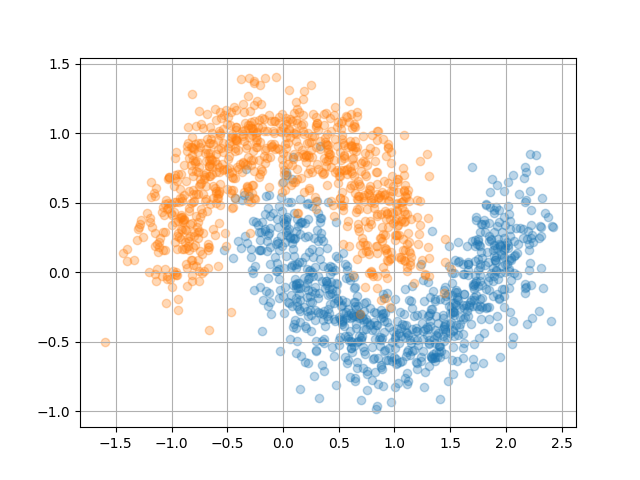

In [9]:
# 2D Check 
samples_x_1 = [x for x,l in zip(train_samples[:,0], train_labels) if l==0]
samples_y_1 = [y for y,l in zip(train_samples[:,1], train_labels) if l==0]

samples_x_2 = [x for x,l in zip(train_samples[:,0], train_labels) if l==1]
samples_y_2 = [y for y,l in zip(train_samples[:,1], train_labels) if l==1]

plt.scatter(samples_x_2, samples_y_2, alpha=0.3)
plt.scatter(samples_x_1, samples_y_1, alpha=0.3)

plt.grid(True)
plt.show()

In [10]:
# add noise data with no target ([0.5, 0.5])

noise_range = [-100, 100]
num_in_row = 50
X1 = np.arange(noise_range[0], noise_range[1]+0.01, (noise_range[1]-noise_range[0])/(1.0*num_in_row))
X1s, X2s = np.meshgrid(X1,X1)
noise_samples = np.reshape(zip(X1s.flatten(),X2s.flatten()),(-1,2))
noise_labels = np.array([np.random.choice([0,1]) for _ in range(len(noise_samples))])

<IPython.core.display.Javascript object>


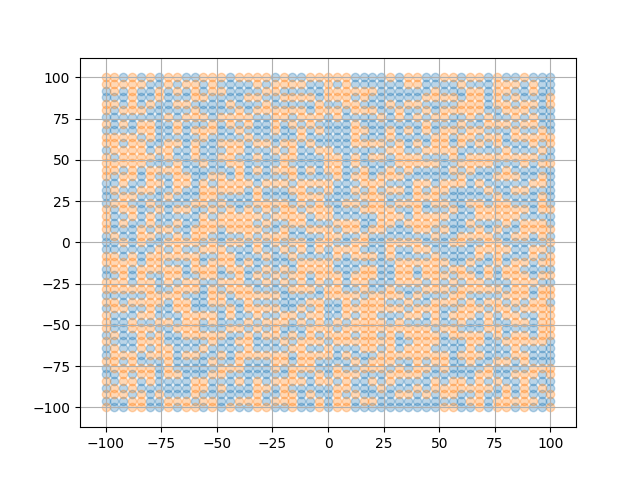

In [11]:
# visualize
# 2D Check 
noise_x = [x for x,l in zip(noise_samples[:,0], noise_labels) if l==0]
noise_y = [y for y,l in zip(noise_samples[:,1], noise_labels) if l==0]
plt.scatter(noise_x, noise_y, alpha=0.3)
noise_x = [x for x,l in zip(noise_samples[:,0], noise_labels) if l==1]
noise_y = [y for y,l in zip(noise_samples[:,1], noise_labels) if l==1]
plt.scatter(noise_x, noise_y, alpha=0.3)
plt.grid(True)
plt.show()

In [12]:
# Noise dataloader
# convert data to pytorch format 
noise_train_x = torch.Tensor(noise_samples)
noise_train_y = torch.Tensor(noise_labels)

my_noise_dataset = torch.utils.data.TensorDataset(noise_train_x, noise_train_y) # create your dataset

my_noise_dataloader = torch.utils.data.DataLoader(my_noise_dataset, batch_size=32, shuffle=True) # create your dataloader


In [13]:
# Moons dataloader
# convert data to pytorch format 
tensor_train_x = torch.Tensor(train_samples)
tensor_train_y = torch.Tensor(train_labels)

tensor_test_x = torch.Tensor(test_samples)
tensor_test_y = torch.Tensor(test_labels)

my_dataset = torch.utils.data.TensorDataset(tensor_train_x, tensor_train_y) # create your dataset
my_test_data = torch.utils.data.TensorDataset(tensor_test_x,tensor_test_y) # create your dataset

my_dataloader = torch.utils.data.DataLoader(my_dataset, batch_size=32, shuffle=True) # create your dataloader
my_test_dataloader = torch.utils.data.DataLoader(my_test_data, batch_size=32, shuffle=True) # create your dataloader

In [14]:
### PART 1: classic feedforward net (linear with bias + tanh)

In [15]:
# loss functions for the classic net
lmbda_l2 = (4.0*0.1/len(my_dataloader.dataset))
print(lmbda_l2)
      
classical_cross_ent_loss = fgnh.def_classical_cross_ent_loss(lmbda_l2)

0.0002442002442


In [16]:
# Initialize the classic network
hidden_layer_sizes = [16,16]
drop_p = 0.01

In [17]:
classic_model = fgnl.Feedforward_Classic_net(in_feats=2, out_feats=2, hidden_layer_sizes=hidden_layer_sizes, drop_p=drop_p)
classic_model.to(device)

Feedforward_Classic_net(
  (hidden_layers): ModuleList(
    (0): Dropout(p=0.01)
    (1): Linear(in_features=2, out_features=16, bias=True)
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.01)
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.01)
  )
  (ib): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fl): Linear(in_features=16, out_features=2, bias=True)
)

In [18]:
# define model params to optimize
classic_optimizer = optim.Adam(filter(lambda p: p.requires_grad, classic_model.parameters()))
# classic_optimizer = optim.RMSprop(filter(lambda p: p.requires_grad, classic_model.parameters()))

In [19]:
epochs = 10

In [20]:
# train for 1 epoch over noise
_ = fgnh.train(classic_model, my_noise_dataloader, 
                             classical_cross_ent_loss, classic_optimizer, epochs=1, save_hist=2, verbose=True, 
                             pred_func=fgnh.cross_ent_pred_accuracy)

Epoch 0 Train set - Average loss: 0.6996, Accuracy: 1306/2601 (50%)


In [21]:
# train the network for N epochs
print("# epochs:", epochs)
classic_train_res = fgnh.train(classic_model, my_dataloader, 
                             classical_cross_ent_loss, classic_optimizer, epochs, save_hist=2, verbose=True, 
                             pred_func=fgnh.cross_ent_pred_accuracy, test_loader=my_test_dataloader)

# epochs: 10
Epoch 0 Train set - Average loss: 0.4834, Accuracy: 1378/1638 (84%)
Test set - Average loss: 0.6042, Accuracy: 351/410 (86%)
Epoch 1 Train set - Average loss: 0.3427, Accuracy: 1416/1638 (86%)
Test set - Average loss: 0.3092, Accuracy: 361/410 (88%)
Epoch 2 Train set - Average loss: 0.3217, Accuracy: 1406/1638 (86%)
Test set - Average loss: 0.2889, Accuracy: 360/410 (88%)
Epoch 3 Train set - Average loss: 0.3133, Accuracy: 1407/1638 (86%)
Test set - Average loss: 0.2916, Accuracy: 359/410 (88%)
Epoch 4 Train set - Average loss: 0.3183, Accuracy: 1414/1638 (86%)
Test set - Average loss: 0.2855, Accuracy: 359/410 (88%)
Epoch 5 Train set - Average loss: 0.3124, Accuracy: 1399/1638 (85%)
Test set - Average loss: 0.2873, Accuracy: 360/410 (88%)
Epoch 6 Train set - Average loss: 0.3058, Accuracy: 1408/1638 (86%)
Test set - Average loss: 0.2850, Accuracy: 359/410 (88%)
Epoch 7 Train set - Average loss: 0.3155, Accuracy: 1401/1638 (86%)
Test set - Average loss: 0.2883, Accuracy: 3

In [22]:
# test the statibility of the model (these numbers should be same as final lines above)
_ = fgnh.test(classic_model, my_dataloader,
                        classical_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

_ = fgnh.test(classic_model, my_test_dataloader,
                        classical_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

Test set - Average loss: 0.2842, Accuracy: 1430/1638 (87%)
Test set - Average loss: 0.2811, Accuracy: 360/410 (88%)


<IPython.core.display.Javascript object>


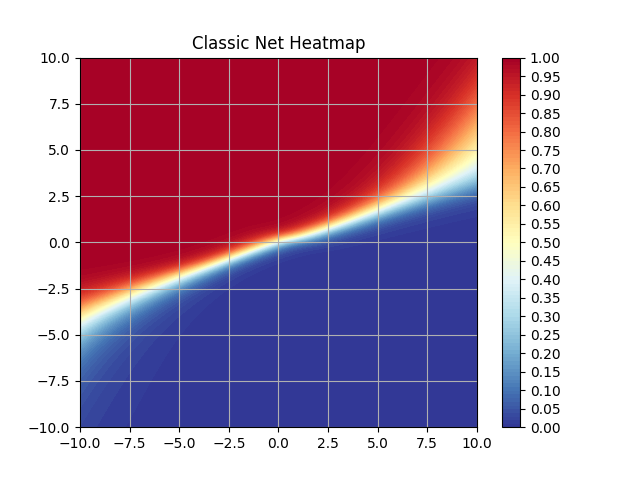

<IPython.core.display.Javascript object>


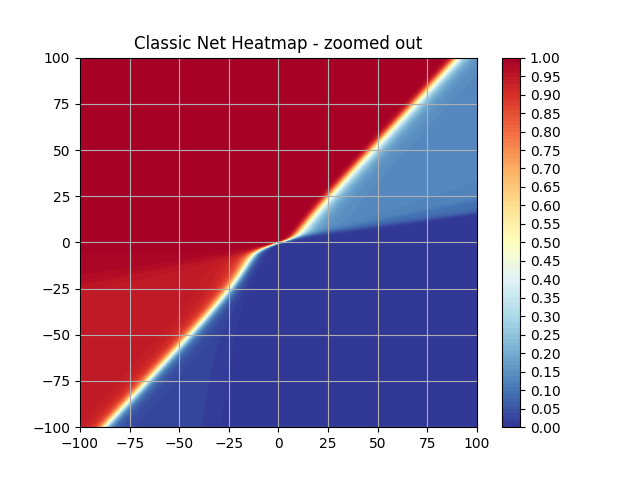

In [23]:
fgnh.plot_2D_heatmap(classic_model, title="Classic Net Heatmap")
fgnh.plot_2D_heatmap(classic_model, title="Classic Net Heatmap - zoomed out", scale=100.0)

In [24]:
### PART 2: fully FGN network

In [25]:
### Loss Functions for the FGN

# importances of the constraints
lmbda_l2 = (4.0*0.1/len(my_dataloader.dataset))
lmbda_sigs = 100.0*lmbda_l2
# sig_params = sum(p.numel() for n,p in fgn_model.named_parameters() if 'sigs' in n)
# lmbda_sigs = (1.0/sig_params)

# lmbda_l2 = 0.0
# lmbda_sigs = 0.0
print("lambda for l2 loss", lmbda_l2)
print("lambda for sigs^2 loss", lmbda_sigs)


fgn_cross_ent_loss = fgnl.def_fgn_cross_ent_loss(lmbda_l2, lmbda_sigs)


lambda for l2 loss 0.0002442002442
lambda for sigs^2 loss 0.02442002442


In [26]:
# fgn specific params
print("hidden layers:", hidden_layer_sizes)
# covariance type: sphere, diag or full
covar_type = 'sphere'
print("covariance:", covar_type)
ordinal = float(2)
print("ordinal for norm:", ordinal)
# non_lin = False
non_lin = True
print("non linearity:", non_lin)
free_biases=True
print("free biases:", free_biases)

print("drop prob:", drop_p)



# Initialize the fgn network
fgn_model = fgnl.Feedforward_FGN_net(in_feats=2, out_feats=2, hidden_layer_sizes=hidden_layer_sizes, drop_p=drop_p,
                                     covar_type=covar_type, ordinal=ordinal, non_lin=non_lin, free_biases=free_biases)
fgn_model.to(device)

hidden layers: [16, 16]
covariance: sphere
ordinal for norm: 2.0
non linearity: True
free biases: True
drop prob: 0.01


Feedforward_FGN_net(
  (hidden_layers): ModuleList(
    (0): Dropout(p=0.01)
    (1): FGN_layer()
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.01)
    (4): FGN_layer()
    (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.01)
  )
  (ib): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fl): FGN_layer()
)

In [27]:
# set fgn biases to zero except first layer and dont train them
fgn_model.hidden_layers[4].biases.requires_grad = False
fgn_model.hidden_layers[4].biases.fill_(0.)
fgn_model.fl.biases.requires_grad = False
fgn_model.fl.biases.fill_(0.)

Parameter containing:
tensor([0., 0.])

In [28]:
# define model params to optimize
fgn_optimizer = optim.Adam(filter(lambda p: p.requires_grad, fgn_model.parameters()))
# fgn_optimizer = optim.RMSprop(filter(lambda p: p.requires_grad, fgn_model.parameters()))

<IPython.core.display.Javascript object>


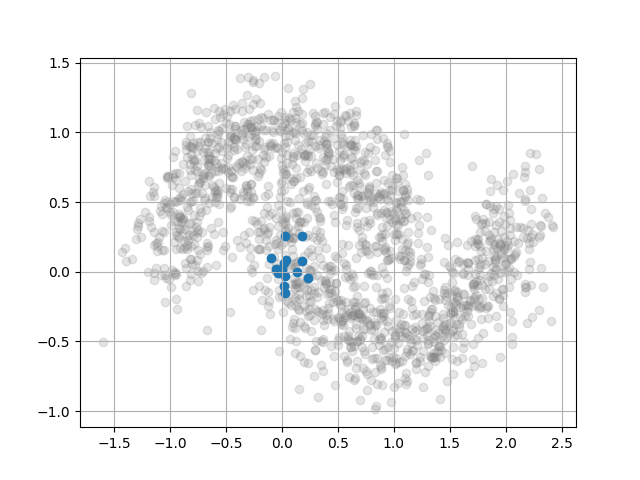

In [29]:
# plot centers of first layer
x = zip(*fgn_model.state_dict()['hidden_layers.1.centers'].detach().cpu().numpy())
plt.scatter(np.concatenate((samples_x_1,samples_x_2)), np.concatenate((samples_y_1,samples_y_2)), alpha=0.2, c='gray')
plt.scatter(x[0], x[1])
# plt.axis([-8,10, -8,10])
plt.grid(True)
plt.show()

In [30]:
# set centers of first layer
fgn_model.set_first_layer_centers(my_dataloader)

<IPython.core.display.Javascript object>


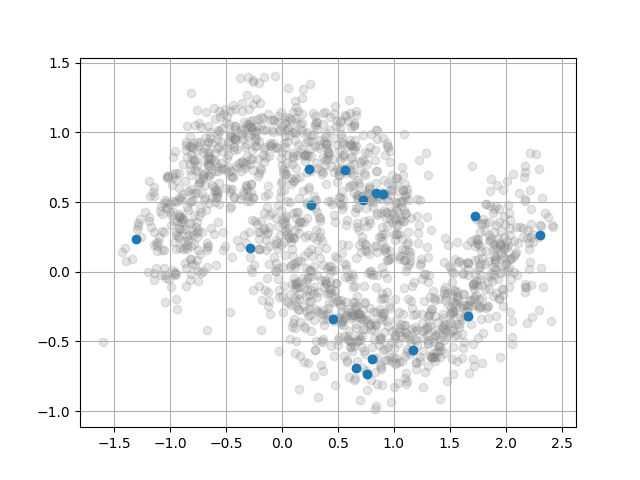

In [31]:
# visualize them
# plot centers of first layer
x = zip(*fgn_model.state_dict()['hidden_layers.1.centers'].detach().cpu().numpy())
plt.scatter(np.concatenate((samples_x_1,samples_x_2)), np.concatenate((samples_y_1,samples_y_2)), alpha=0.2, c='gray')
plt.scatter(x[0], x[1])
# plt.axis([-8,10, -8,10])
plt.grid(True)
plt.show()

In [32]:
# pretrain on noise
_ = fgnh.train(fgn_model, my_noise_dataloader, 
                             fgn_cross_ent_loss, fgn_optimizer, epochs=10, save_hist=2, verbose=True, 
                             pred_func=fgnh.cross_ent_pred_accuracy)


Epoch 0 Train set - Average loss: 2.3418, Accuracy: 1341/2601 (52%)
Epoch 1 Train set - Average loss: 1.4728, Accuracy: 1345/2601 (52%)
Epoch 2 Train set - Average loss: 1.2500, Accuracy: 1403/2601 (54%)
Epoch 3 Train set - Average loss: 1.1370, Accuracy: 1390/2601 (53%)
Epoch 4 Train set - Average loss: 1.0652, Accuracy: 1388/2601 (53%)
Epoch 5 Train set - Average loss: 1.0155, Accuracy: 1369/2601 (53%)
Epoch 6 Train set - Average loss: 0.9788, Accuracy: 1388/2601 (53%)
Epoch 7 Train set - Average loss: 0.9497, Accuracy: 1378/2601 (53%)
Epoch 8 Train set - Average loss: 0.9260, Accuracy: 1384/2601 (53%)
Epoch 9 Train set - Average loss: 0.9058, Accuracy: 1395/2601 (54%)


In [33]:
# train the network for N epochs
fgn_train_res = fgnh.train(fgn_model, my_dataloader, 
                             fgn_cross_ent_loss, fgn_optimizer, epochs, save_hist=2, verbose=True, 
                             pred_func=fgnh.cross_ent_pred_accuracy, test_loader=my_test_dataloader)

Epoch 0 Train set - Average loss: 0.7522, Accuracy: 1298/1638 (79%)
Test set - Average loss: 0.7369, Accuracy: 349/410 (85%)
Epoch 1 Train set - Average loss: 0.5896, Accuracy: 1402/1638 (86%)
Test set - Average loss: 0.5168, Accuracy: 366/410 (89%)
Epoch 2 Train set - Average loss: 0.5367, Accuracy: 1412/1638 (86%)
Test set - Average loss: 0.4823, Accuracy: 365/410 (89%)
Epoch 3 Train set - Average loss: 0.4990, Accuracy: 1420/1638 (87%)
Test set - Average loss: 0.4414, Accuracy: 369/410 (90%)
Epoch 4 Train set - Average loss: 0.4517, Accuracy: 1449/1638 (88%)
Test set - Average loss: 0.3989, Accuracy: 376/410 (92%)
Epoch 5 Train set - Average loss: 0.4224, Accuracy: 1469/1638 (90%)
Test set - Average loss: 0.3715, Accuracy: 382/410 (93%)
Epoch 6 Train set - Average loss: 0.3828, Accuracy: 1516/1638 (93%)
Test set - Average loss: 0.3263, Accuracy: 388/410 (95%)
Epoch 7 Train set - Average loss: 0.3408, Accuracy: 1533/1638 (94%)
Test set - Average loss: 0.3015, Accuracy: 392/410 (96%)


In [34]:
# test the statibility of the model (these numbers should be close as final lines above, depending)

print("Random Eval OFF")
fgn_model.set_random_eval(False)
_ = fgnh.test(fgn_model, my_dataloader,
                        fgn_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

_ = fgnh.test(fgn_model, my_test_dataloader,
                        fgn_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

print("Random Eval ON")
fgn_model.set_random_eval(True)
_ = fgnh.test(fgn_model, my_dataloader,
                        fgn_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

_ = fgnh.test(fgn_model, my_test_dataloader,
                        fgn_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

Random Eval OFF
Test set - Average loss: 0.2568, Accuracy: 1597/1638 (97%)
Test set - Average loss: 0.2843, Accuracy: 391/410 (95%)
Random Eval ON
Test set - Average loss: 0.2568, Accuracy: 1597/1638 (97%)
Test set - Average loss: 0.2843, Accuracy: 391/410 (95%)


<IPython.core.display.Javascript object>


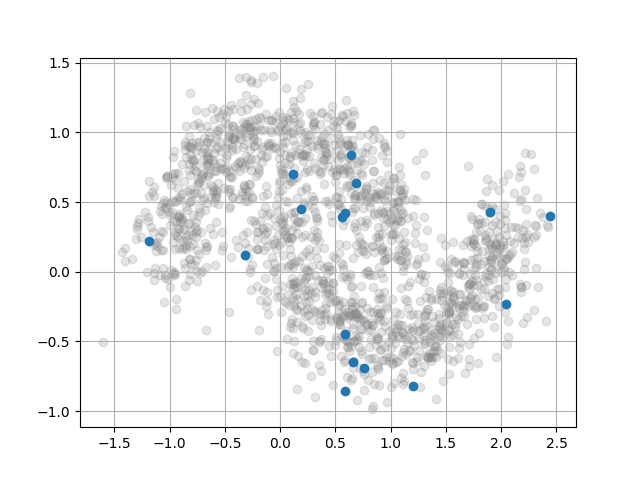

In [35]:
# plot centers of first layer
x = zip(*fgn_model.state_dict()['hidden_layers.1.centers'].detach().cpu().numpy())
plt.scatter(np.concatenate((samples_x_1,samples_x_2)), np.concatenate((samples_y_1,samples_y_2)), alpha=0.2, c='gray')
plt.scatter(x[0], x[1])
# plt.axis([-8,10, -8,10])
plt.grid(True)
plt.show()

<IPython.core.display.Javascript object>


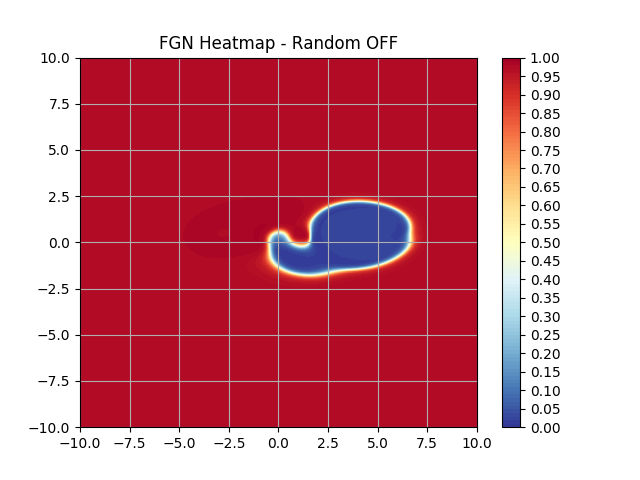

<IPython.core.display.Javascript object>


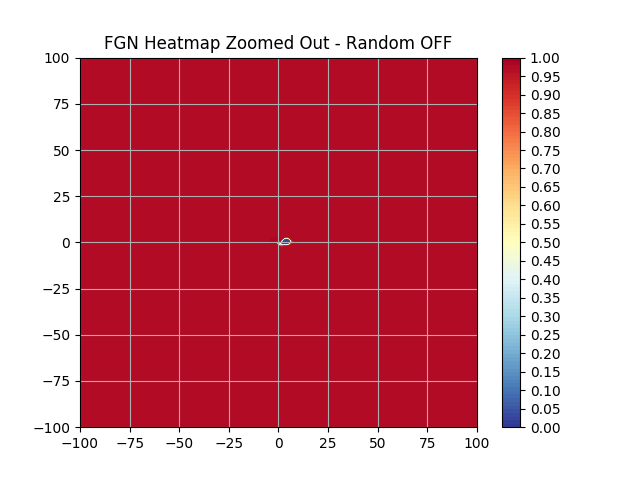

<IPython.core.display.Javascript object>


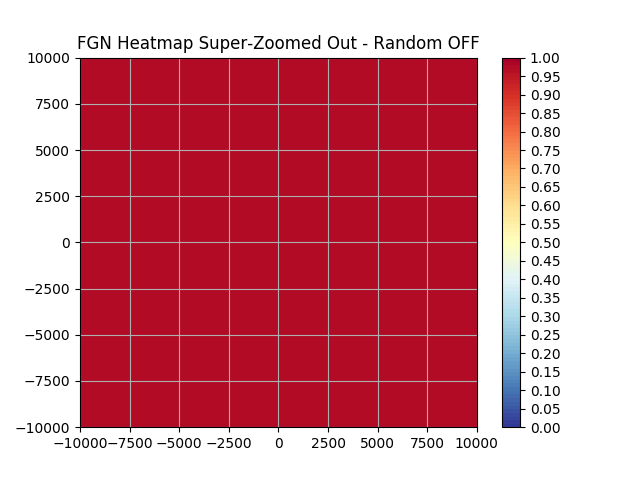

In [36]:
fgn_model.set_random_eval(False)
fgnh.plot_2D_heatmap(fgn_model, title="FGN Heatmap - Random OFF")
fgnh.plot_2D_heatmap(fgn_model, title="FGN Heatmap Zoomed Out - Random OFF", scale=100.0)
fgnh.plot_2D_heatmap(fgn_model, title="FGN Heatmap Super-Zoomed Out - Random OFF", scale=10000.0)

<IPython.core.display.Javascript object>


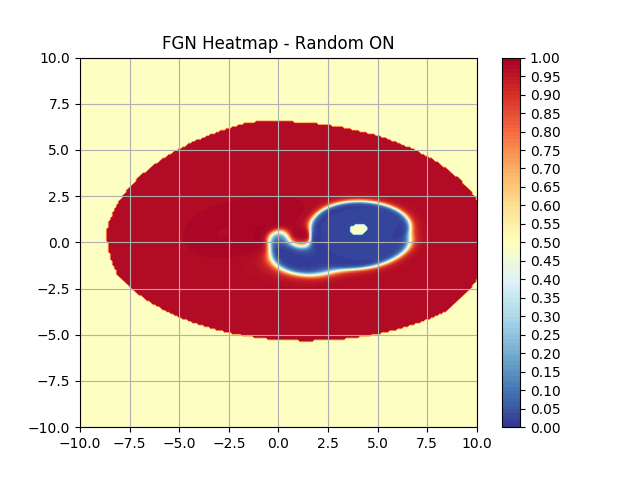

<IPython.core.display.Javascript object>


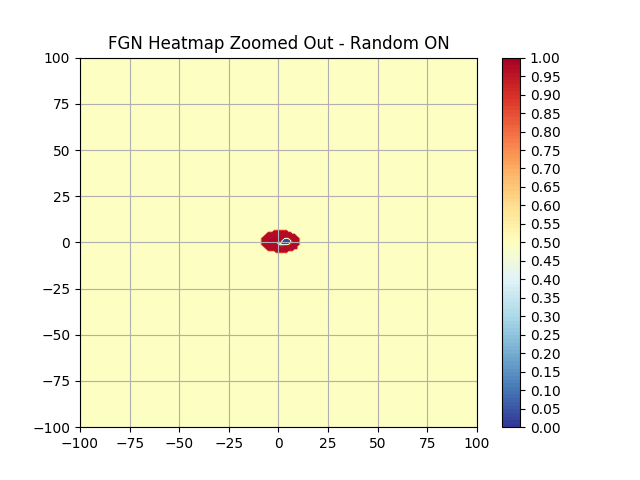

<IPython.core.display.Javascript object>


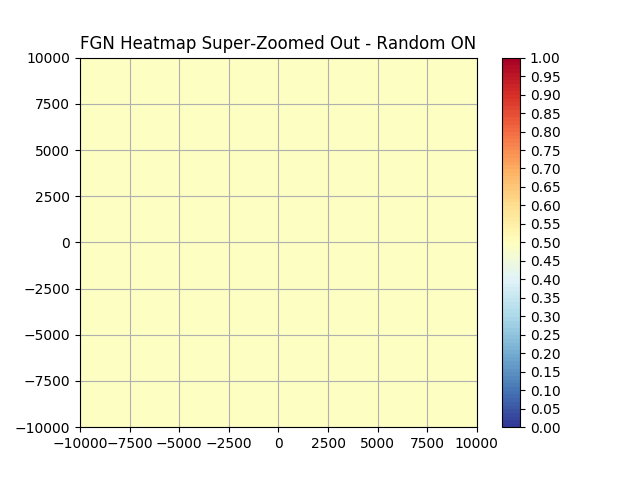

In [37]:
# compute predictions for heatmap with random eval
fgn_model.set_random_eval(True)
fgnh.plot_2D_heatmap(fgn_model, title="FGN Heatmap - Random ON")
fgnh.plot_2D_heatmap(fgn_model, title="FGN Heatmap Zoomed Out - Random ON", scale=100.0)
fgnh.plot_2D_heatmap(fgn_model, title="FGN Heatmap Super-Zoomed Out - Random ON", scale=10000.0)

<IPython.core.display.Javascript object>


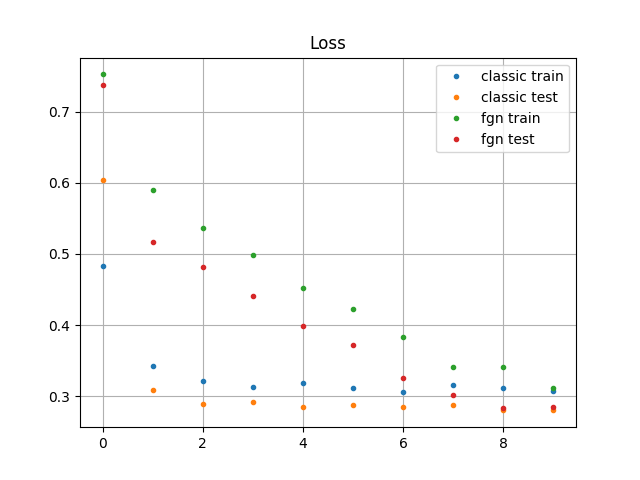

<IPython.core.display.Javascript object>


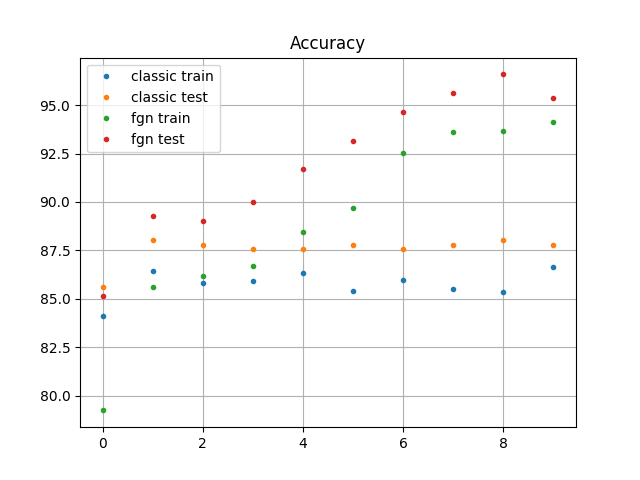

In [38]:
# acc and loss hist
plt.plot(classic_train_res['train_loss_hist'], marker='.', linestyle=' ', label='classic train')
plt.plot(classic_train_res['test_loss_hist'], marker='.', linestyle=' ', label='classic test')
plt.plot(fgn_train_res['train_loss_hist'], marker='.', linestyle=' ', label='fgn train')
plt.plot(fgn_train_res['test_loss_hist'], marker='.', linestyle=' ', label='fgn test')
plt.grid()
plt.legend()
plt.title('Loss')
plt.show()

plt.plot(classic_train_res['train_acc_hist'], marker='.', linestyle=' ', label='classic train')
plt.plot(classic_train_res['test_acc_hist'], marker='.', linestyle=' ', label='classic test')
plt.plot(fgn_train_res['train_acc_hist'], marker='.', linestyle=' ', label='fgn train')
plt.plot(fgn_train_res['test_acc_hist'], marker='.', linestyle=' ', label='fgn test')
plt.grid()
plt.legend()
plt.title('Accuracy')
plt.show()

In [39]:
### plot some FGN param movement during training

<IPython.core.display.Javascript object>


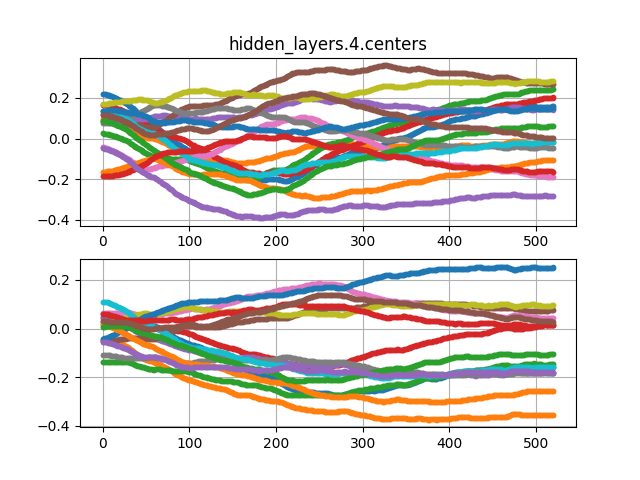

<IPython.core.display.Javascript object>


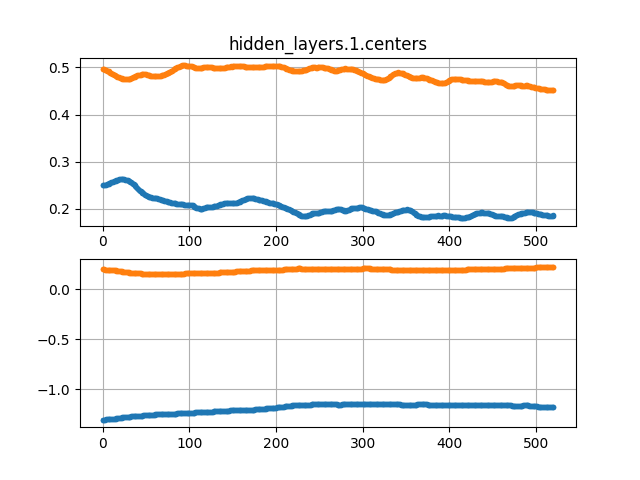

<IPython.core.display.Javascript object>


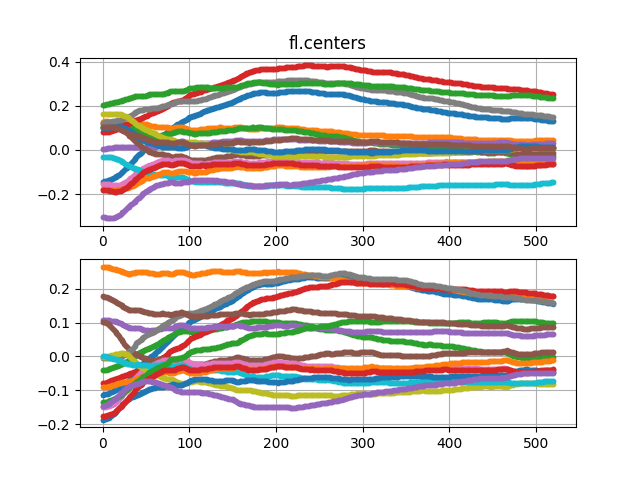

In [40]:
# plot centers history for only some hidden layer neuron
fgnl.plot_centers_histories(fgn_train_res['histories'])

<IPython.core.display.Javascript object>


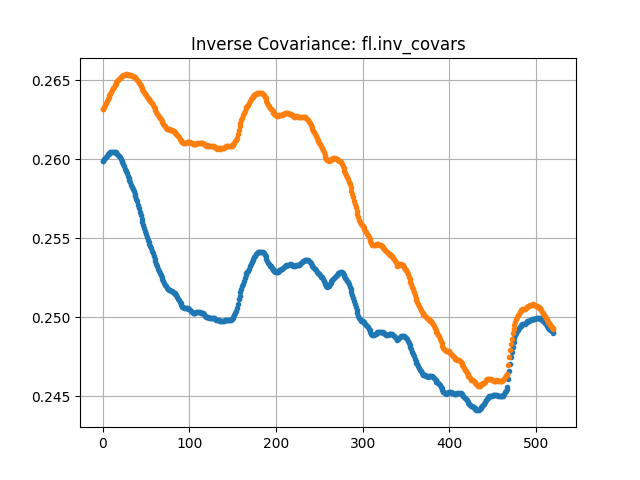

<IPython.core.display.Javascript object>


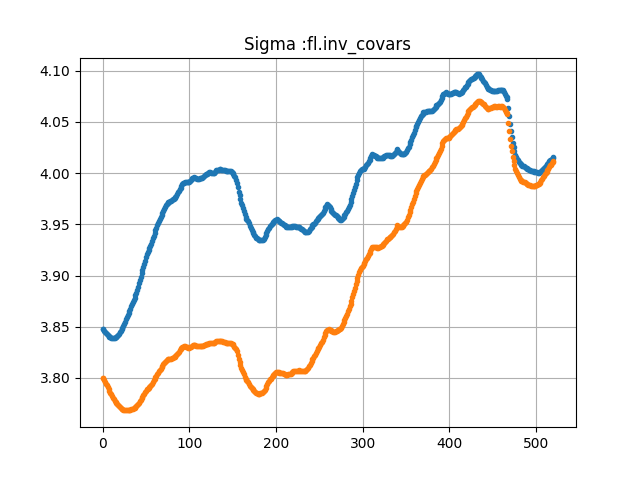

/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


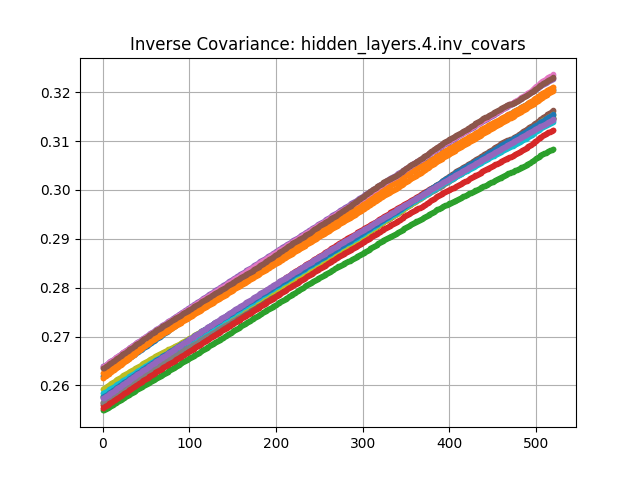

<IPython.core.display.Javascript object>


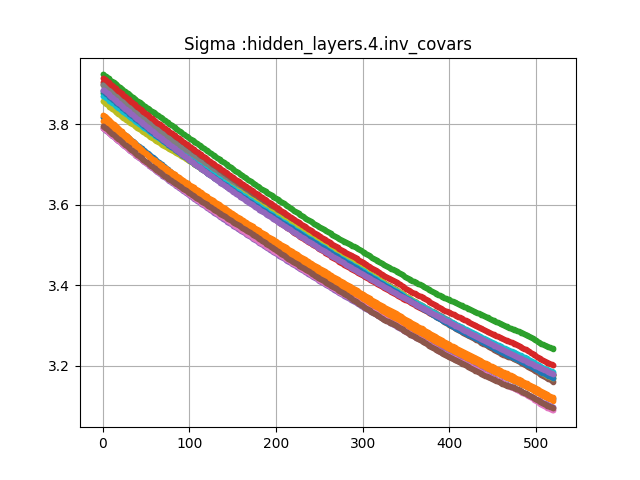

<IPython.core.display.Javascript object>


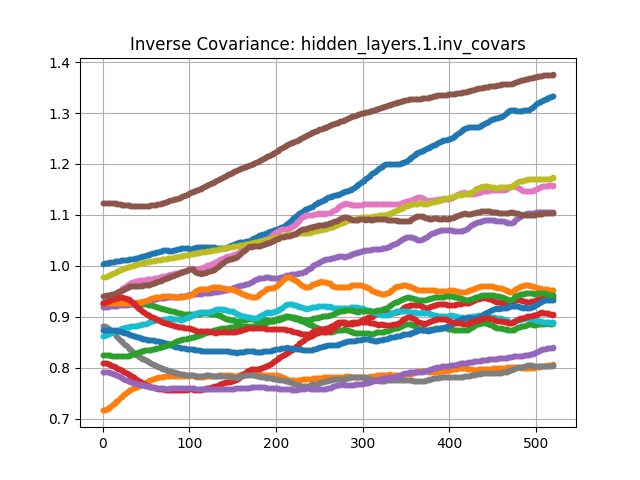

<IPython.core.display.Javascript object>


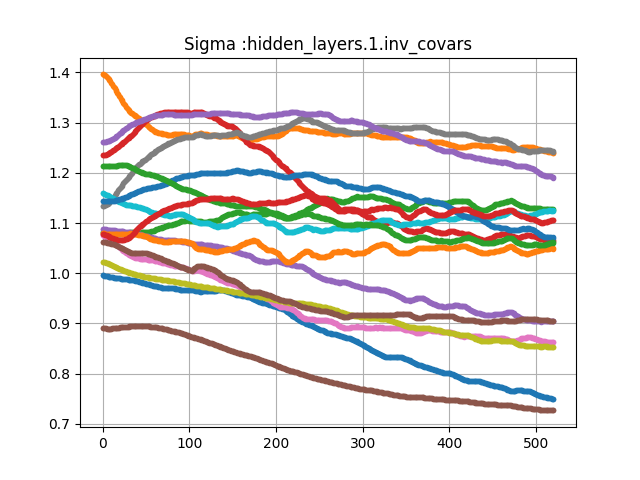

In [41]:
# check that inv covar has gone up, sigmas down, and trace down if covar_type=='full'
fgnl.plot_sigmas_histories(fgn_train_res['histories'])

In [42]:
fgn_model.hidden_layers[4].biases

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])